# Document Classifier
February 2024
* Johanna Norell
* Andreas Helgesson
* Axel Blom

Establishing a baseline classifier for text and investigating relative performance to BERT model.

In [ ]:
# Install the SimpleTransformers package which contains a wrapped version of BERT
!pip install simpletransformers

In [ ]:
# Import necessary packages
from simpletransformers.classification import ClassificationModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob # For finding directories with wildcard *
from statistics import multimode
from google.colab import files
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

In [ ]:
# Upload the CSV files to Colab
uploaded = files.upload()

Saving a3_test.tsv to a3_test.tsv
Saving a3_train_final.tsv to a3_train_final.tsv


In [ ]:
# Read in the data
data_df = pd.read_csv('a3_train_final.tsv', sep='\t', names=['labels','text']) # Read in data
data_df = data_df.sample(frac=1.0, random_state=0) # Randomize row order

In [ ]:
# Function to calculate F1-score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

# Preprocessing Data

In [ ]:
len(data_df)

50068

The dataset contains 50068 entries. Because we only want our models to train on clean and accurate data, we will have to clean it. There are two possible ways to do this:



1.   Take the label that is most common among different annotators
2.   Only look at the data where all annotaters agreed



We first look at alternative 1:

In [ ]:
# Having a look at the result of the annotation
data_df["labels"].value_counts().to_dict()

{'1/1': 19248,
 '0/0': 18221,
 '0/-1': 2434,
 '1/-1': 2082,
 '1/0': 1467,
 '0/1': 1182,
 '1': 945,
 '0': 931,
 '1/1/1/1': 681,
 '0/0/0/0': 644,
 '0/0/0': 419,
 '1/1/1': 360,
 '0/0/0/0/0': 144,
 '1/1/1/1/1': 100,
 '1/1/1/1/1/1': 99,
 '0/0/0/0/0/0': 95,
 '0/0/0/0/0/0/0': 53,
 '0/0/0/0/0/0/0/0': 47,
 '1/1/1/1/1/1/1': 42,
 '0/1/0': 35,
 '0/0/-1/0': 33,
 '0/-1/0': 32,
 '1/1/1/1/1/1/1/1': 32,
 '1/1/1/-1': 31,
 '0/0/0/0/0/0/0/0/0': 31,
 '0/0/0/-1': 29,
 '0/0/-1': 27,
 '1/-1/1': 24,
 '1/1/-1': 23,
 '1/1/-1/1': 22,
 '1/0/1': 22,
 '1/1/0': 21,
 '1/0/0': 18,
 '0/1/1': 17,
 '0/0/0/0/0/0/0/0/0/0/0': 17,
 '1/1/0/1': 16,
 '0/0/0/0/0/0/0/0/0/0': 15,
 '1/1/1/1/1/1/1/1/1': 15,
 '1/1/1/1/1/1/1/1/1/1': 14,
 '0/0/0/1': 14,
 '0/0/0/0/0/0/0/0/0/0/0/0/0': 12,
 '1/1/-1/-1': 12,
 '0/0/1/0': 12,
 '1/1/1/0': 12,
 '0/0/0/0/0/0/0/0/0/0/0/0': 11,
 '0/1/-1': 10,
 '1/0/-1': 10,
 '0/1/1/1': 9,
 '0/0/0/0/0/0/0/0/0/0/0/0/0/0/0': 9,
 '0/0/0/0/0/0/0/0/0/0/0/0/0/0': 9,
 '0/-1/-1': 8,
 '0/0/1': 8,
 '1/1/1/1/1/1/1/1/1/1/1/1':

In [ ]:
# If there is no most common value, we return an arbritrary value so that we can keep track of these
default_value = 2

# Function to process each Prediction value
def process_most_common(x):
    modes = multimode(x.split("/"))
    if len(modes) > 1:
        # Returnining a default value since the most common value does not exist
        return default_value
    else:
        # Returnining the most common value
        return int(modes[0])

# Processing the label for each instance if we look at the most common annotation
majority_label = data_df["labels"].apply(process_most_common)

# Looking at the outcome
majority_label.value_counts()

 1    21837
 0    20981
 2     7228
-1       22
Name: labels, dtype: int64

Clean data would only be where either 0 or 1 is a majority label amongst the annotators, in which case we would have 21837+20981=42818 entries left. That would be 42818/50068=85.5%.

We now check alternative 2. We will remove any rows where the annotations to not match (the annotators did not agree).

For the same reason, we also remove any rows where the label is '-1'. Lastly, we format the labels column so that it only contains one value (eg '1' instead of '1/1/1/1').

In [ ]:
# Check if annotations in the label column are all identical
def check_annotations_agree(row):
    return row['labels'].split('/')[1:] == row['labels'].split('/')[:-1] # Using splice to see wheter all annotations are equal

# Apply function to check if labels agree
data_df['annotations_agree'] = data_df.apply(check_annotations_agree, axis=1)

# Remove rows with mismatched labels or label = -1
data_df = data_df.loc[(data_df['annotations_agree'] == True) & ('-1' not in data_df['labels'])]

# Shorten labels to only contain one copy of the value
def first_character_only(row):
    return int(row['labels'][0])
data_df['labels'] = data_df.apply(first_character_only, axis=1)

# Drop column we do not need anymore
data_df.drop(columns=['annotations_agree'])

,labels,text
2065,0,All of this was a scam and planned with the wo...
25859,0,Mass Sterilization
48998,0,the vaccine was brought forward too quickly
29486,0,Now they're forcing us to get the vaccine. Wha...
4064,0,Better to fight off a virus naturally with a 9...
...,...,...
32103,1,Second shot is making me feel like I just ran ...
30403,1,People are still dying because they refused to...
21243,1,Im in favor of this. If it’s really needed to ...
42613,0,We can still love and care for our neighbors w...


In [ ]:
len(data_df)

42247

With the data cleaned, we find that we have 42247 entries that are well formatted. This means that 50068/42247=0.844, or 84.4% of the data is well formatted and ok to use by our standards. The difference between alternative 1 and 2 is negligible in terms of quantity of cleaned data, but we opt to go with alternative 2 as this would remove any entires where annotators disagreed, hopefully leading to as little ambiguity in the clean data as possible.

Lastly, we split this data into traning and testing:

In [ ]:
# Split data into training and testing sets
train_data_df, test_data_df = train_test_split(data_df)

# Perceptron - Baseline

We first set a baseline using the same technique provided in the recent lecture. We vectorize the data using CountVectorizer and TfidVectorizer, and train a Perceptron model with default configuration.

In [ ]:
# Split into X and Y
X = train_data_df['text']
Y = train_data_df['labels']

# Vectorize data
vectorizer1 = CountVectorizer()
X_v1 = vectorizer1.fit_transform(X)

vectorizer2 = TfidfVectorizer()
X_v2 = vectorizer2.fit_transform(X)

In [ ]:
# Fit and check the cross validation score for each
cross_val_score(Perceptron(), X_v1, Y, cv=10).mean()

0.7963074257883346

In [ ]:
cross_val_score(Perceptron(), X_v2, Y, cv=10).mean()

0.7914155359209004

In [ ]:
# Prepare test data
X_test = test_data_df['text']
Y_test = test_data_df['labels']

# Evaluate both models on the test data
X_test_1 = vectorizer1.transform(X_test)
clf1 = Perceptron()
clf1.fit(X_v1, Y)
clf1_preds = clf1.predict(X_test_1)

X_test_2 = vectorizer2.transform(X_test)
clf2 = Perceptron()
clf2.fit(X_v2, Y)
clf2_preds = clf2.predict(X_test_2)

# Calculate and print out the F1-score
print(f'F1-Score Perceptron (CountVectorizer): {f1_multiclass(Y_test.to_numpy(), clf1_preds)}')
print(f'F1-Score Perceptron (TfidVectorizer): {f1_multiclass(Y_test.to_numpy(), clf2_preds)}')

F1-Score Perceptron (CountVectorizer): 0.8002272296913463
F1-Score Perceptron (TfidVectorizer): 0.7851732626396516


We find that, on the testing data, Perceptron achieves an F-score of 80.0% when using CountVectorizer, and 78.5% when using TfidVectorizer. This is surprising, as Tfid is supposed to provide better classification than ordinary count vectorization. However, the difference is very small, and almost negligible.

# BERT - Baseline

We first establish a baseline accuracy for BERT by using the pretrained *bert-base-uncased* model. In the next section, *BERT - Tuned*, we train our own model by tuning our own hyperparameters.

In [ ]:
# https://www.philschmid.de/bert-text-classification-in-a-different-language

In [ ]:
# Load the pre-trained bert-base-uncased model and configure it for binary classification
model = ClassificationModel(
    "bert",
    "bert-base-uncased",
    num_labels = 2, # Binary classification (Pro/Anti-vaccine)
    use_cuda = True # For training speed, use T4 GPU in Colab
)

# Evaluate the model on the testing data
result, model_outputs, wrong_predictions = model.eval_model(test_data_df, f1=f1_multiclass, acc=accuracy_score)
print(f"F1-Score: {result['f1']}")  # https://simpletransformers.ai/docs/classification-models/#training-a-classification-model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

F1-Score: 0.49384586252603674


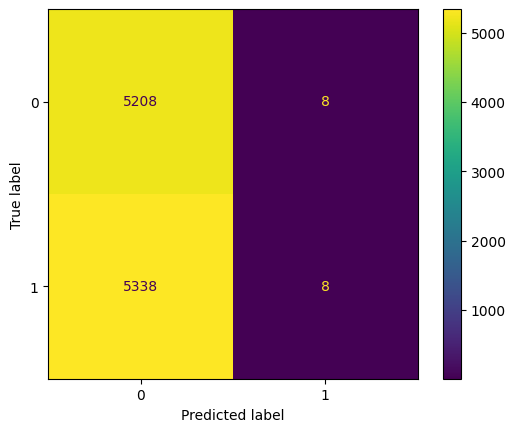

In [ ]:
# We visualize the model predictions in a confusion matrix
conf_mx = np.array([[result['tn'], result['fp']],
                    [result['fn'], result['tp']]])
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mx)
disp.plot()
plt.show()

We note that this model has a tendency to always classify the comment/text as anti-vaccination. Naturally, the F1-Score is around 50% as the model always predicts the same alternative.

# BERT - Tuned

We now train our custom BERT model to try to improve on our accuracy.

In [ ]:
# https://simpletransformers.ai/docs/classification-models/#training-a-classification-model
# https://simpletransformers.ai/docs/tips-and-tricks/

In [ ]:
# Clear outputs from previous runs
!rm -r outputs

# Define our hyperparameter
nr_epochs = 5

# Define hyperparameters
train_args = {
    "reprocess_input_data": True, # Read original data, not cached
    "fp16": False, # For GPU compatability
    "num_train_epochs": nr_epochs,
    'overwrite_output_dir': True
    }

# Create a ClassificationModel with out specific parameters
model = ClassificationModel(
    "bert",
    "bert-base-uncased",
    num_labels = 2, # Binary classification (Pro/Anti-vaccine)
    args = train_args,
    use_cuda = True # For training speed, use T4 GPU in Colab
)

# Train the model on the data. The funcion train_model() outputs a checkpoint copy of the model after each epoch, which we will use later on to check for the optimal value of nr_epochs
model.train_model(train_data_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/3961 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/3961 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/3961 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/3961 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/3961 [00:00<?, ?it/s]

(19805, 0.14916293869453642)

In [ ]:
# Initialize arrays for data we want to visualize
train_scores = []
test_scores = []

# For each model checkpoint
for i in range(1, nr_epochs+1):

  print(f'Evaluating model at {i} epochs:')

  # Find directory of checkpoint
  directory = glob.glob('outputs/*-epoch-'+str(i))[0]

  # Load in model
  checkpoint_model = ClassificationModel(
    'bert', directory
  )

  # Evaluate on training and testing data
  result_train_data, model_outputs, wrong_predictions = checkpoint_model.eval_model(train_data_df, f1=f1_multiclass, acc=accuracy_score)
  result_test_data, model_outputs, wrong_predictions = checkpoint_model.eval_model(test_data_df, f1=f1_multiclass, acc=accuracy_score)

  # Save F1-scores
  train_scores.append(result_train_data['f1'])
  test_scores.append(result_test_data['f1'])

Evaluating model at 1 epochs:


  0%|          | 0/63 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating model at 2 epochs:


  0%|          | 0/63 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating model at 3 epochs:


  0%|          | 0/63 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating model at 4 epochs:


  0%|          | 0/63 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Evaluating model at 5 epochs:


  0%|          | 0/63 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

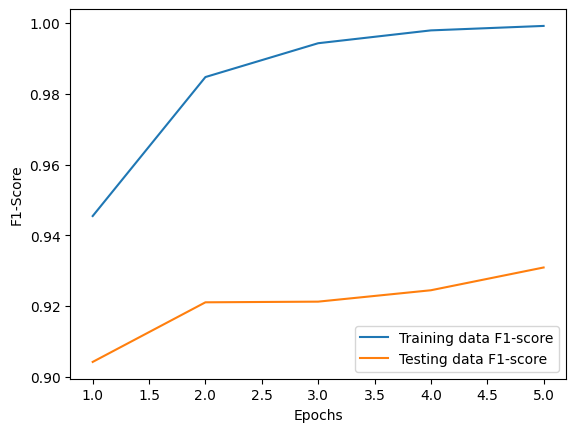

In [ ]:
# Visualize results
plt.plot(list(range(1,nr_epochs+1)), train_scores, label='Training data F1-score')
plt.plot(list(range(1,nr_epochs+1)), test_scores, label='Testing data F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

We note that the model quickly begins to overfit on the training data when nr_epochs is increased. We reached the best accuracy at 2 epochs, after which it begins to overfit, as evident by the plateau in the training data score curve, without improving the testing data accuracy score. We visualize this best model in an confusion matrix.

  0%|          | 0/21 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

F1-Score: 0.9308843022154895


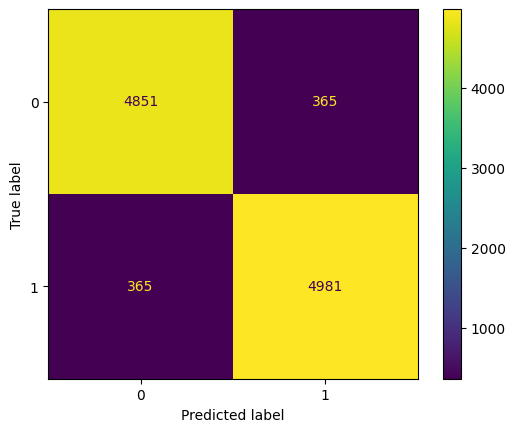

In [ ]:
# Find directory of checkpoint after X epochs
directory = glob.glob('outputs/*-epoch-'+str(2))[0] # TODO choose appropriate epoch when full dataset is available

# Load in model
checkpoint_model = ClassificationModel(
    'bert', directory
)

# Evaluate the model on the testing data
result, model_outputs, wrong_predictions = model.eval_model(test_data_df, f1=f1_multiclass, acc=accuracy_score)
print(f"F1-Score: {result['f1']}")  # https://simpletransformers.ai/docs/classification-models/#training-a-classification-model

# Visualize the results in a confusion matrix
conf_mx = np.array([[result['tn'], result['fp']],
                    [result['fn'], result['tp']]])
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mx)
disp.plot()
plt.show()

We get an F1-Score of 0.9308843022154895, which beats the Percepttron baseline by over 13 percentage points and the BERT baseline by over 40.

# Final Testing on Evaluation Data

In out testing so far, a self trained BERT model trained for 2 epochs achieved the ebst accuracy score without overfitting.

We now train such a model on the entire dataset, and then evaluate it on a separate evalution dataset, which will emulate how the model might perform in a real production environment.

In [ ]:
# Read in evaluation data
evaluation_data_df = pd.read_csv('a3_test.tsv', sep='\t', names=['labels','text'])

In [ ]:
# Train
train_args = {
    "reprocess_input_data": True, # Read original data, not cached
    "fp16": False, # For GPU compatability
    "num_train_epochs": 2,
    'overwrite_output_dir': True
    }

# Create a ClassificationModel with out specific parameters
model = ClassificationModel(
    "bert",
    "bert-base-uncased",
    num_labels = 2, # Binary classification (Pro/Anti-vaccine)
    args = train_args,
    use_cuda = True # For training speed, use T4 GPU in Colab
)

# Train the model on the entire dataset
model.train_model(data_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/5281 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/5281 [00:00<?, ?it/s]

(10562, 0.24711537968153735)

  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

F1-Score: 0.9426189308484552


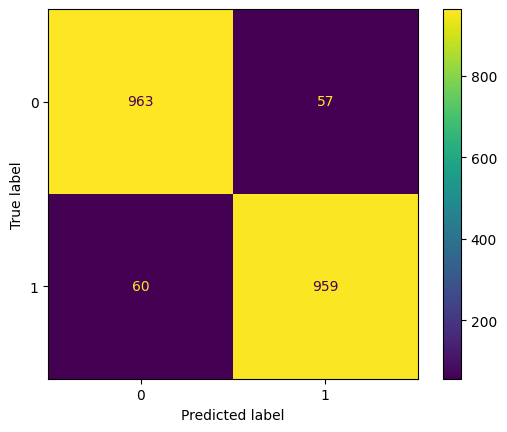

In [ ]:
# Evaluate
result_train_data, model_outputs, wrong_predictions = model.eval_model(evaluation_data_df, f1=f1_multiclass, acc=accuracy_score)
print(f"F1-Score: {result_train_data['f1']}")

# Visualize the model predictions in a confusion matrix
conf_mx = np.array([[result_train_data['tn'], result_train_data['fp']],
                    [result_train_data['fn'], result_train_data['tp']]])
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mx)
disp.plot()
plt.show()

We achieve a final F1 accuracy score of 94.3% on the evaluation data. To analyze what comments the model was unable to correctly classify, we can take a look at its incorrect predictions:

In [ ]:
for entry in wrong_predictions:
  print(entry.text_a)

I don't know what's in it. As if they know what's in the hamburgers they eat, the milk they drink, the high fructose corn syrup they consume... what a tragedy of stupidity.
I trust my immune system just translates to "I don't know how vaccines work."
It is a pity that people are dying from the vaccine that would otherwise be healthy. These are not the same people that would have died from the virus, mind you. These people would have lived long healthy lives.
Vaccines are saving lives meanwhile romania being the least vaccinated and also least infected country in the whole europe
We take other risks so taking this one shouldnt be a problem is the dumbest argument there is...
13k idiots. Natural selection. Let the people who wanna be safe. Don’t take it. More for the smarter people.
A vaccine takes a number of years to be developed, this alone is reason enough to be antivaxx
After I recommended a patient get vaccinated with the bivalent booster, he sent me a message that he had gotten th

It is understandable that the model had difficulties in correctly classifying these phrases. Many are ambiguous, see for example "Do these vaccines prevent Covid19", which is a question rather than an expression of opinion.

Also, see "People who refuse to take the vaccine are the 21st century Rosa Parks.". With context, we understand that this comment expresses an anti-vaccination stance (the commenter implies that refusing the vaccine is comparable to Rosa Parks refusing to give up her bus seat as an act of defiance against discriminatory laws and traditions). However, as the model has no knowledge of who Rosa Parks did or who she is, it is understandable that the model would have issues correctly classifying these comments.

There are also examples that are very clear, and which are surprising the model did not get right. For example, see "count me in too. im now an antivaxxer". Though the first part of the comment is a bit ambiguous, the latter does provide a clear anti-vaccination stance.